In [53]:
import ezc3d
from scipy.signal import butter, filtfilt
import numpy as np

def load_marker_data(c3d_path):
    """
    Load marker positions from C3D file.
    
    Args:
        c3d_path: Path to the C3D file
        
    Returns:
        marker_positions: Array of shape (framecount, num_markers, 3) - marker positions over time
    """
    c3d = ezc3d.c3d(c3d_path)
    
    # Extract points data: shape (4, num_markers, framecount)
    points = c3d['data']['points']
    marker_positions = points[:3, :, :]  # (3, num_markers, framecount) ignore the 4th dimension (all 1's)
    # Transpose to get (framecount, num_markers, 3)
    marker_positions = marker_positions.transpose(2, 1, 0)
    

    return marker_positions / 1000  # Convert from mm to meters


def lowpass_filter(data: np.ndarray, cutoff_freq: float, fs: float) -> np.ndarray:
    nyquist = 0.5 * fs
    norm_cutoff = cutoff_freq / nyquist
    b, a = butter(N=4, Wn=norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=0)


c3d_path = "/home/darren/Desktop/hippobotamus/SVD/C3D_DATA/20201128_ID_2_0008.c3d"
marker_clouds = load_marker_data(c3d_path)
marker_clouds = lowpass_filter(marker_clouds, cutoff_freq=5, fs=240)

## print marker indices associated with representative saddle markers
c3d = ezc3d.c3d(c3d_path)
labels = c3d['parameters']['POINT']['LABELS']['value']

def to_str(x):
    return x.decode() if isinstance(x, (bytes, bytearray)) else str(x)

indices = np.array([i for i, lab in enumerate(labels) if to_str(lab).strip().endswith(('11', '12', '20'))])
print(indices)
print(np.array(labels)[indices])

[38 51 64 65]
['ID2_L_ShoulderBlade_20' 'ID2_R_ShoulderBlade_20' 'ID2_C_Back_2_11'
 'ID2_C_Back_3_12']


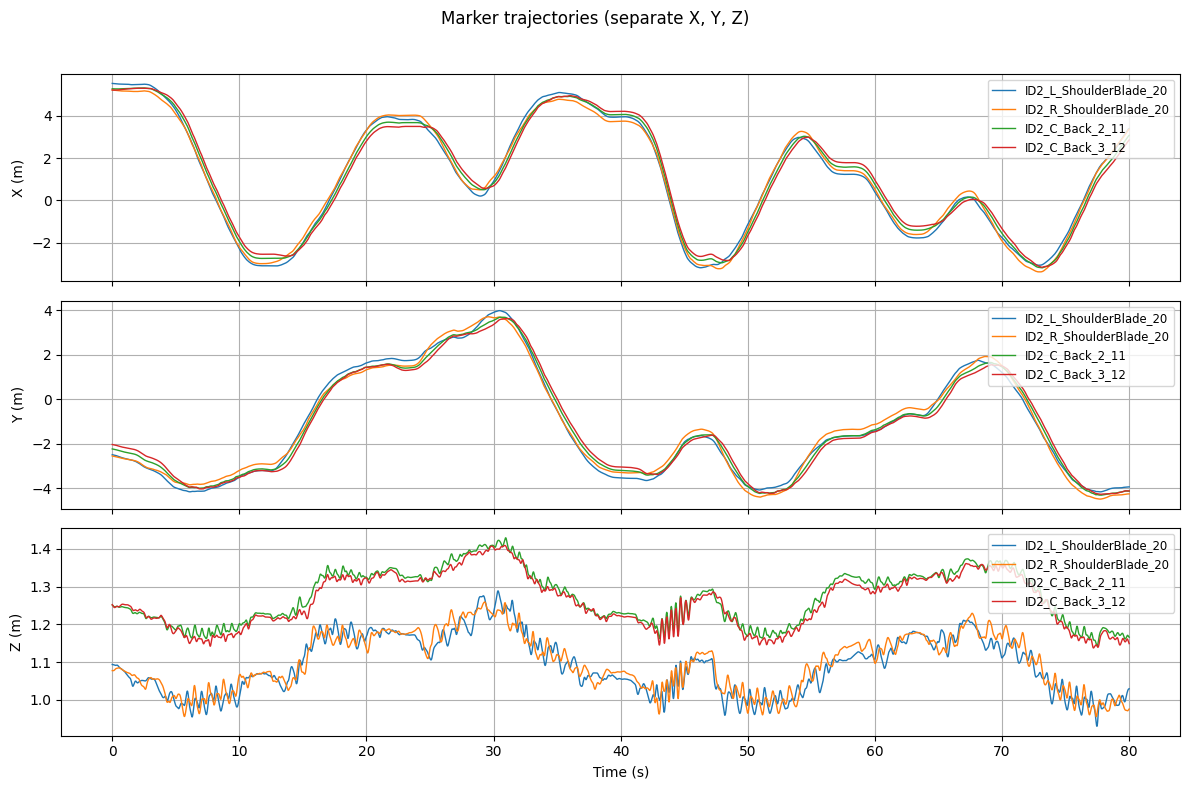

In [54]:
import matplotlib.pyplot as plt

fs = 240.0
n_frames = marker_clouds.shape[0]
t = np.arange(n_frames) / fs

label_names = [to_str(labels[i]).strip() for i in indices]

traj = marker_clouds[:, indices, :]  # shape (frames, n_selected, 3)

fig2, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
coords = ['X', 'Y', 'Z']

for coord_idx, ax_ in enumerate(axes):
    for m_idx in range(traj.shape[1]):
        ax_.plot(t, traj[:, m_idx, coord_idx], lw=1, label=label_names[m_idx])
    ax_.set_ylabel(f'{coords[coord_idx]} (m)')
    ax_.grid(True)
    ax_.legend(loc='upper right', fontsize='small')

axes[-1].set_xlabel('Time (s)')
fig2.suptitle('Marker trajectories (separate X, Y, Z)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [67]:
from scipy.spatial.transform import Rotation

def estimate_rigid_body_pose(markers):
    """
    Estimate the rigid-body pose (centroid + orientation) from marker positions over time,
    using only anatomical frame definitions (no SVD).

    Args:
        markers: Array of shape (n_frames, n_markers, 3) with marker positions

    Returns:
        centroids: Array of shape (n_frames, 3) with centroid positions
        rotation_matrices: Array of shape (n_frames, 3, 3) with rotation matrices
    """
    n_frames = markers.shape[0]
    centroids = np.nanmean(markers, axis=1)
    rotation_matrices = np.empty((n_frames, 3, 3))
    
    # Assuming markers[:, 0] is L20, markers[:, 1] is R20, markers[:, 2] is 11, markers[:, 3] is 12
    for frame in range(n_frames):
        # Define anatomical coordinate system directly from markers
        forward_vec = markers[frame, 2] - markers[frame, 3]  # back to front vector
        side_vec = markers[frame, 0] - markers[frame, 1]     # right to left vector
        
        # Create orthogonal coordinate system
        x_axis = forward_vec / np.linalg.norm(forward_vec)
        temp_z = np.cross(forward_vec, side_vec)
        z_axis = temp_z / np.linalg.norm(temp_z)
        y_axis = np.cross(z_axis, x_axis)
        
        # Store rotation matrix (columns are the axes of the anatomical frame)
        rotation_matrices[frame] = np.column_stack((x_axis, y_axis, z_axis))
    
    return centroids, rotation_matrices

# compute centroid of the 4 selected markers (traj shape: (n_frames, 4, 3))
centroids, rotation_matrices = estimate_rigid_body_pose(traj)


In [75]:
# Calculate centroid linear velocities in global frame first
global_linear_velocities = np.gradient(centroids, 1.0/fs, axis=0)

# Initialize arrays for local frame velocities
local_linear_velocities = np.zeros_like(global_linear_velocities)
local_angular_velocities = np.zeros((n_frames, 3))

# For each frame
for i in range(n_frames):
    # Transform linear velocity from global to local frame
    # R.T converts from global to local coordinates
    local_linear_velocities[i] = rotation_matrices[i].T @ global_linear_velocities[i]
    
    # Calculate angular velocities in local frame
    if i > 0:
        R_prev = rotation_matrices[i-1]
        R_curr = rotation_matrices[i]
        
        # Calculate relative rotation (same as before)
        rel_rotation = Rotation.from_matrix(R_curr @ R_prev.T)
        
        # Get rotation vector (global frame)
        global_rot_vec = rel_rotation.as_rotvec()
        
        # Transform to local frame using the previous frame's orientation
        local_rot_vec = R_prev.T @ global_rot_vec
        
        # Scale by 1/dt to get angular velocity (rad/s)
        local_angular_velocities[i] = local_rot_vec * fs

# First frame angular velocity
local_angular_velocities[0] = local_angular_velocities[1]

# Combine local frame velocities into matrix A
A = np.hstack((local_linear_velocities, local_angular_velocities))

print(f"Rigid body velocities shape: {A.shape}")
# Calculate norms of linear velocities
lin_vel_norms = np.linalg.norm(local_linear_velocities, axis=1)  # Shape: (n_frames,)
print(f"max Linear velocity: {np.max(lin_vel_norms):.3f} m/s")

# Calculate norms of angular velocities
ang_vel_norms = np.linalg.norm(local_angular_velocities, axis=1)  # Shape: (n_frames,)
print(f"max Angular velocity: {np.max(ang_vel_norms):.3f} rad/s")

Rigid body velocities shape: (19200, 6)
max Linear velocity: 2.567 m/s
max Angular velocity: 1.964 rad/s


In [82]:
# Compute SVD of the rigid-body velocity matrix A (already in the notebook)
# Use thin SVD to get U (n_frames x 6), S (6,), Vt (6 x 6)
U, S, Vt = np.linalg.svd(A, full_matrices=False)

print(f"U shape: {U.shape}, S shape: {S.shape}, Vt shape: {Vt.shape}")
print("Singular values:", S)

U shape: (19200, 6), S shape: (6,), Vt shape: (6, 6)
Singular values: [133.47446518  79.88416526  55.63601654  38.44247759  19.66952453
  13.6599693 ]


In [ ]:
# 3-rank approximation of A using existing SVD (U, S, Vt)
k = 3

U_k = U[:, :k]        # (n_frames, k)
S_k = S[:k]           # (k,)
Vt_k = Vt[:k, :]      # (k, 6)

A_k = (U_k * S_k) @ Vt_k

# Diagnostics
residual = A - A_k
fro_err = np.linalg.norm(residual, ord='fro')
fro_A = np.linalg.norm(A, ord='fro')
sv_energy_captured = np.sum(S_k**2) / np.sum(S**2)

print(f"A shape: {A.shape}, A_k shape: {A_k.shape}")
print(f"Frobenius norm of A: {fro_A:.6f}")
print(f"Frobenius norm of residual (A - A_k): {fro_err:.6f}")
print(f"Variance (energy) captured by top {k} components: {sv_energy_captured*100:.4f}%")

A shape: (19200, 6), A_k shape: (19200, 6)
Frobenius norm of A: 171.299703
Frobenius norm of residual (A - A_k): 45.291379
Variance (energy) captured by top 3 components: 93.0093%


In [85]:
# Extract local linear and angular velocities from the low-rank approximation
local_linear_vel_k = A_k[:, :3]  # (n_frames, 3)
local_angular_vel_k = A_k[:, 3:] # (n_frames, 3)

# Initialize arrays for global velocities
global_linear_vel_k = np.zeros_like(local_linear_vel_k)

# Transform local linear velocities to global frame
for i in range(n_frames):
    # R converts from local to global coordinates
    global_linear_vel_k[i] = rotation_matrices[i] @ local_linear_vel_k[i]

# Now let's integrate to get positions and orientations
# Initialize arrays for the reconstructed trajectory
pos_reconstructed = np.zeros((n_frames, 3))
rot_reconstructed = np.zeros((n_frames, 3, 3))

# Set initial position and orientation
pos_reconstructed[0] = centroids[0]
rot_reconstructed[0] = rotation_matrices[0]

# Euler integration
dt = 1.0/fs  # Time step

for i in range(1, n_frames):
    # Update position using global linear velocity
    pos_reconstructed[i] = pos_reconstructed[i-1] + global_linear_vel_k[i-1] * dt
    
    # Update orientation using local angular velocity
    # Convert angular velocity to rotation vector
    rot_vec = local_angular_vel_k[i-1] * dt
    
    # Create a rotation object from rotation vector
    rel_rot = Rotation.from_rotvec(rot_vec)
    
    # Previous rotation as Rotation object
    prev_rot = Rotation.from_matrix(rot_reconstructed[i-1])
    
    # Apply relative rotation (in local frame)
    new_rot = prev_rot * rel_rot
    
    # Store the new rotation matrix
    rot_reconstructed[i] = new_rot.as_matrix()

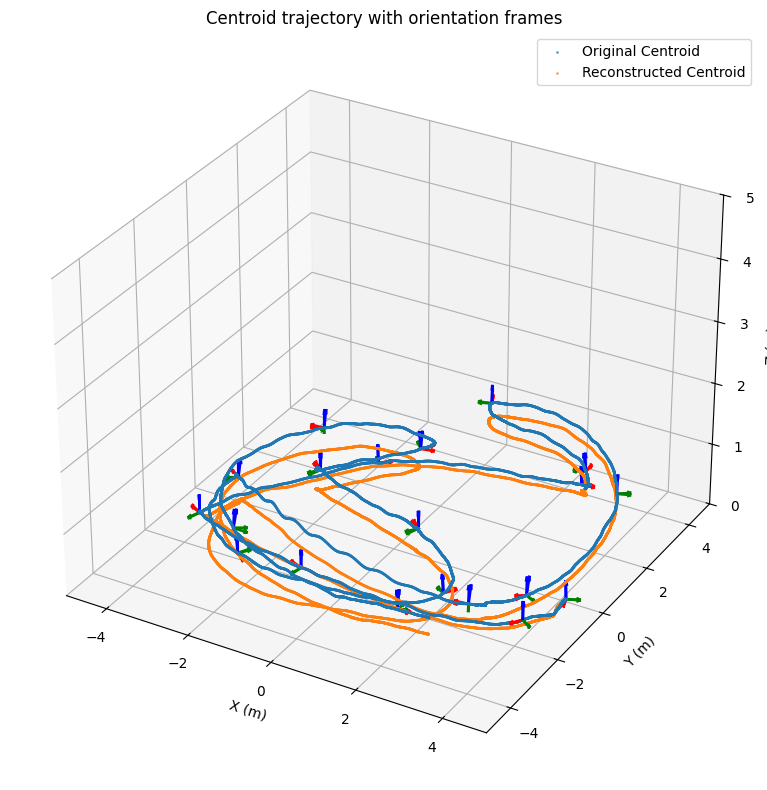

In [88]:
fig = plt.figure(figsize=(8, 8))
ax3 = fig.add_subplot(111, projection='3d')

# Plot the centroid trajectory
ax3.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s=1, c='C0', alpha=0.6, label='Original Centroid')
ax3.scatter(pos_reconstructed[:, 0], pos_reconstructed[:, 1], pos_reconstructed[:, 2], s=1, c='C1', alpha=0.6, label='Reconstructed Centroid')


# Select points at regular intervals to show the coordinate frames
interval = 1000  # Show a coordinate frame every `interval` frames
selected_frames = range(0, len(centroids), interval)

# Scale factor for the coordinate frame axes
scale = .3

# Colors for the three axes
colors = ['r', 'g', 'b']  # X, Y, Z

# For each selected frame, draw the coordinate frame
for i in selected_frames:
    # Get the centroid position
    position = centroids[i]
    
    # Get the rotation matrix directly from the precomputed matrices
    rotation_matrix = rotation_matrices[i]
    rotation_matrix_reconstructed = rot_reconstructed[i]

    # Draw the three axes
    for axis in range(3):
        direction = rotation_matrix[:, axis]  # Get the axis direction
        ax3.quiver(position[0], position[1], position[2],
                  direction[0], direction[1], direction[2],
                  length=scale, color=colors[axis], linewidth=2)
        
    for axis in range(3):
        direction = rotation_matrix_reconstructed[:, axis]  # Get the axis direction
        ax3.quiver(position[0], position[1], position[2],
                  direction[0], direction[1], direction[2],
                  length=scale, color=colors[axis], linewidth=2)

ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_zlabel('Z (m)')
ax3.set_title('Centroid trajectory with orientation frames')

# set axis limits from data for a better view
ax3.set_xlim(-5, 5)
ax3.set_ylim(-5, 5)
ax3.set_zlim(0, 5)

plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
Vk = Vt_k.T
print('x-velocity (forward motion) variance contribution: ', np.dot(Vk[0,:]**2, S_k**2)/np.sum(S_k**2))
print('y-velocity (lateral motion) variance contribution: ', np.dot(Vk[1,:]**2, S_k**2)/np.sum(S_k**2))
print('z-velocity (vertical motion) variance contribution: ', np.dot(Vk[2,:]**2, S_k**2)/np.sum(S_k**2))
print('omega x (roll) variance contribution: ', np.dot(Vk[3,:]**2, S_k**2)/np.sum(S_k**2))
print('omega y (pitch) variance contribution: ', np.dot(Vk[4,:]**2, S_k**2)/np.sum(S_k**2))
print('omega z (yaw) variance contribution: ', np.dot(Vk[5,:]**2, S_k**2)/np.sum(S_k**2))

x-velocity variance contribution:  0.645127250845441
y-velocity variance contribution:  0.035099775409542594
z-velocity variance contribution:  0.0025001706264610713
omega x variance contribution:  0.11895167635246705
omega y variance contribution:  0.00033841419360790617
omega z variance contribution:  0.19798271257248157
